In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glove6b100dtxt/glove.6B.100d.txt
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [3]:
from torch.utils.data import Dataset, DataLoader

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
tweet = pd.read_csv('../input/nlp-getting-started/train.csv')
test = pd.read_csv('../input/nlp-getting-started/test.csv')

Text(0, 0.5, 'sample')

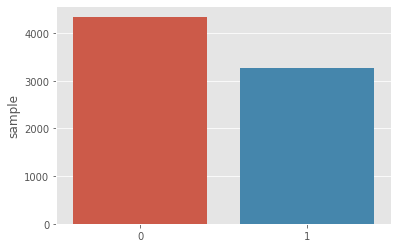

In [5]:
x=tweet.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('sample')

# Preprocess

<h5> Based on thie kernel => https://www.kaggle.com/code/shahules/basic-eda-cleaning-and-glove </h5>

In [6]:
df = pd.concat([tweet, test])

In [7]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

df['text'] = df['text'].apply(lambda x : remove_URL(x))

In [8]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

df['text'] = df['text'].apply(lambda x : remove_html(x))

In [9]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

df['text'] = df['text'].apply(lambda x : remove_emoji(x))

In [10]:
def remove_punct(text):
    table = str.maketrans('','',string.punctuation)
    return text.translate(table)

df['text'] = df['text'].apply(lambda x : remove_punct(x))

In [11]:
df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake Ma...,1.0
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1.0
2,5,NaN,NaN,All residents asked to shelter in place are be...,1.0
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1.0
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as s...,1.0
...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,NaN
3259,10865,NaN,NaN,Storm in RI worse than last hurricane My citya...,NaN
3260,10868,NaN,NaN,Green Line derailment in Chicago,NaN
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook HWO,NaN


In [12]:
def create_corpus(df):
    corpus = []
    for tweet in tqdm(df['text']):
        words = [word.lower() for word in word_tokenize(tweet) if ((word.isalpha() == 1) & (word not in stop))]
        
        corpus.append(words)
        
    return corpus

corpus = create_corpus(df)

100%|██████████| 10876/10876 [00:02<00:00, 4518.61it/s]


In [13]:
MAX_LEN = 50
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences = tokenizer_obj.texts_to_sequences(corpus)
tweet_pad = pad_sequences(sequences, maxlen=MAX_LEN, truncating='post', padding='post')

word_index = tokenizer_obj.word_index

In [14]:
from itertools import islice

# Word index result
dict(islice(word_index.items(), 0, 10))

{'i': 1,
 'the': 2,
 'like': 3,
 'amp': 4,
 'im': 5,
 'a': 6,
 'fire': 7,
 'get': 8,
 'new': 9,
 'via': 10}

# DataLoader

In [15]:
# Convert tweet_pad to Long tensor
total = torch.Tensor(tweet_pad)
total = total.to(torch.long)

In [16]:
# Split train and test dataset
X_train = total[:7613]
y_train = torch.Tensor(df['target'].iloc[:7613])

X_test = total[7613:]

# Split tran and valid datset
train_cnt = int(X_train.size(0)*0.8)
valid_cnt = X_train.size(0) - train_cnt

indices = torch.randperm(X_train.size(0))

In [17]:
train_x, valid_x = torch.index_select(
    X_train,
    dim = 0,
    index=indices
).split([train_cnt, valid_cnt], dim=0)


train_y, valid_y = torch.index_select(
    y_train,
    dim=0,
    index=indices
).split([train_cnt, valid_cnt],dim=0)

In [18]:
class TweetLoader(Dataset):
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels.long()
        
        super().__init__()
        
    def __len__(self):
        return self.data.size(0)
    
    def __getitem__(self, idx):
        
        x = self.data[idx]
        y = self.labels[idx]
        
        return x,y

In [19]:
train_loader = DataLoader(
    dataset=TweetLoader(train_x, train_y),
    batch_size=32,
    shuffle=True
)

valid_loader = DataLoader(
    dataset=TweetLoader(valid_x, valid_y),
    batch_size=32,
    shuffle=True
)

# Model

<h5> 1DConvNet and Rnn LSTM

In [20]:
class CNNClassifier(nn.Module):

    def __init__(
        self,
        input_size,
        word_vec_size,
        n_classes,
        use_batch_norm=False,
        dropout_p=.5,
        window_sizes=[3,4,5],
        n_filters=[100,100,100],
    ):
        self.input_size = input_size
        self.word_vec_size = word_vec_size
        self.n_classes = n_classes
        self.use_batch_norm = use_batch_norm
        self.dropout_p = dropout_p

        self.window_sizes = window_sizes
        self.n_filters = n_filters

        super().__init__()

        self.emb = nn.Embedding(input_size, word_vec_size)
        self.feature_extractors = nn.ModuleList()

        for window_size, n_filters in zip(window_sizes, n_filters):
            self.feature_extractors.append(
                nn.Sequential(
                    nn.Conv2d(
                        in_channels=1,
                        out_channels=n_filters,
                        kernel_size = (window_size, word_vec_size),
                    ),
                    nn.ReLU(),
                    nn.BatchNorm2d(n_filter) if use_batch_norm else nn.Dropout(dropout_p),
                )
            )
            
        self.generator = nn.Linear(sum(self.n_filters), n_classes)
        
        self.activation = nn.LogSoftmax(dim=-1)

    def forward(self, x):

        x = self.emb(x)
    
        min_length = max(self.window_sizes)
        
        if min_length > x.size(1):

            pad = x.new(x.size(0), min_length - x.size(1), self.word_vec_size).zero_()

            x = torch.cat([x,pad], dim=1)

        x = x.unsqueeze(1)
        cnn_outs = []
        for block in self.feature_extractors:
            cnn_out = block(x)
            
            
            cnn_out = nn.functional.max_pool1d(
                input=cnn_out.squeeze(-1),
                kernel_size=cnn_out.size(-2)
            ).squeeze(-1)

            cnn_outs += [cnn_out]

        cnn_outs = torch.cat(cnn_outs, dim=-1)

        y = self.activation(self.generator(cnn_outs))

        return y
    

class RNNClassifier(nn.Module):

    def __init__(
        self,
        input_size,
        word_vec_size,
        hidden_size,
        n_classes,
        n_layers=4,
        dropout_p=.3,
    ):

        self.input_size = input_size
        self.word_vec_size = word_vec_size
        self.hidden_size = hidden_size
        self.n_classes = n_classes
        self.n_layers = n_layers
        self.dropout_p = dropout_p

        super().__init__()

        self.emb = nn.Embedding(input_size, word_vec_size)
        self.rnn = nn.LSTM(
            input_size=word_vec_size,
            hidden_size=hidden_size,
            num_layers=n_layers,
            dropout=dropout_p,
            batch_first=True,
            bidirectional=True,
        )
        self.generator = nn.Linear(hidden_size * 2, n_classes)

        self.activation = nn.LogSoftmax(dim=-1)

    def forward(self,x):
        # |x| = {batch_size, length}
        x = self.emb(x)

        # |x| = {batch_size, length, word_vec_size}
        x, _ = self.rnn(x)

        # |x| x= {batch_size, length, hidden_size *2}
        y = self.activation(self.generator(x[:,-1]))

        # |y| = {batch_size, n_classes}
        return y

In [21]:
def train(model, optimizer, train_loader, valid_loader, crit, n_epochs):
    train_loss_history = []
    valid_loss_history = []

    for epoch in range(1, n_epochs + 1):

        train_loss, valid_loss = 0,0

        model.train()
        for x, y in train_loader:
            optimizer.zero_grad()
            y_hat = model(x)
            loss = crit(y_hat, y)

            train_loss += float(loss)

            loss.backward()
            optimizer.step()

        model.eval()
        for x, y in valid_loader:

            y_hat = model(x)
            loss = crit(y_hat, y)

            valid_loss += float(loss)

        train_loss_history.append(train_loss / len(train_loader))
        valid_loss_history.append(valid_loss / len(valid_loader))

        print('Epoch {} / {} train_loss : {} valid_loss : {}'.format(epoch, n_epochs,train_loss/len(train_loader),valid_loss/len(valid_loader)))
    
    
    return model, train_loss_history, valid_loss_history

In [22]:
input_size = len(word_index) + 1
word_vec_size = 100
num_class = 2
n_epochs = 30

cnn_model = CNNClassifier(input_size,word_vec_size,num_class)
optimizer = optim.Adam(cnn_model.parameters())
crit = nn.NLLLoss()

cnn_model, cnn_train_history, cnn_valid_history = train(cnn_model, optimizer, train_loader, valid_loader, crit, n_epochs)

Epoch 1 / 30 train_loss : 0.6469433285803071 valid_loss : 0.5635445198665062
Epoch 2 / 30 train_loss : 0.4785889438621661 valid_loss : 0.5183894274135431
Epoch 3 / 30 train_loss : 0.34821875252960865 valid_loss : 0.5058522777010998
Epoch 4 / 30 train_loss : 0.2646577313581374 valid_loss : 0.5023661578694979
Epoch 5 / 30 train_loss : 0.20000166664416877 valid_loss : 0.5772877242416143
Epoch 6 / 30 train_loss : 0.17148444737205332 valid_loss : 0.5788123471041521
Epoch 7 / 30 train_loss : 0.14237702749084427 valid_loss : 0.5903083185354868
Epoch 8 / 30 train_loss : 0.12821674490766843 valid_loss : 0.5995225574200352
Epoch 9 / 30 train_loss : 0.12365956998951928 valid_loss : 0.5817751114567121
Epoch 10 / 30 train_loss : 0.11655096105587576 valid_loss : 0.7114534371842941
Epoch 11 / 30 train_loss : 0.11405482943564732 valid_loss : 0.6274593910202384
Epoch 12 / 30 train_loss : 0.10895206318700111 valid_loss : 0.6912880533685287
Epoch 13 / 30 train_loss : 0.10507453209111048 valid_loss : 0.67

In [23]:
input_size = len(word_index)
word_vec_size = 100
hidden_size=64
num_class = 2
n_epochs = 30

rnn_model = rnn_model = RNNClassifier(input_size,word_vec_size,hidden_size,num_class)
optimizer = optim.Adam(rnn_model.parameters())
crit = nn.NLLLoss()

rnn_model, rnn_train_history, rnn_valid_history = train(rnn_model, optimizer, train_loader, valid_loader, crit, n_epochs)

Epoch 1 / 30 train_loss : 0.6856584430365038 valid_loss : 0.6812393255531788
Epoch 2 / 30 train_loss : 0.6843762585005835 valid_loss : 0.6809012964367867
Epoch 3 / 30 train_loss : 0.6841152194906904 valid_loss : 0.6813980005681515
Epoch 4 / 30 train_loss : 0.68481598100113 valid_loss : 0.6830645638207594
Epoch 5 / 30 train_loss : 0.6847005801675208 valid_loss : 0.6808579601347446
Epoch 6 / 30 train_loss : 0.684307588956743 valid_loss : 0.6810932233929634
Epoch 7 / 30 train_loss : 0.6847775019900337 valid_loss : 0.6821338968972365
Epoch 8 / 30 train_loss : 0.6843065004698269 valid_loss : 0.6817565262317657
Epoch 9 / 30 train_loss : 0.6843171675167783 valid_loss : 0.6810501180589199
Epoch 10 / 30 train_loss : 0.6841155259397017 valid_loss : 0.680806660403808
Epoch 11 / 30 train_loss : 0.6843502477825624 valid_loss : 0.6818079849084219
Epoch 12 / 30 train_loss : 0.6839505324813084 valid_loss : 0.680450384815534
Epoch 13 / 30 train_loss : 0.6842781286589138 valid_loss : 0.6802250780165195


# Submit

<h5> Looks like rnn model does not work ...

In [24]:
result = cnn_model(X_test)

In [25]:
result = result.argmax(axis=1)

In [26]:
submission = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')

In [27]:
submission['target'] = result

In [28]:
submission.to_csv('./sample_submission.csv',index=False)